In [0]:
#%pip install tensorflow
#%pip install mlflow

## Statistikos Departamento Užduotis
### RNN Model implementation for covid-19 cases forecast in Lithuania a.k.a. Visualisations using spark

#### 1. Retrieve data and packages

In [0]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot

from pyspark.sql.functions import desc, round
from pyspark import SparkFiles
from pyspark.ml.evaluation import RegressionEvaluator
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [0]:
spark.sparkContext.addFile("https://get.data.gov.lt/datasets/gov/lsd/covid19/SvieslenciuStatistika/:format/csv")

In [0]:
df = spark.read.csv("file://"+SparkFiles.get("csv"), header=True, inferSchema= True)
display(df)

_type,_id,_revision,ab_neg_day,ab_pos_day,ab_prc_day,ab_tot_day,ag_neg_day,ag_pos_day,ag_prc_day,ag_tot_day,date,dgn_neg_day,dgn_pos_day,dgn_prc_day,dgn_tot_day,dgn_tot_day_gmp,municipality_code,pcr_neg_day,pcr_pos_day,pcr_prc_day,pcr_tot_day,daily_deaths_def1,daily_deaths_def2,daily_deaths_def3,daily_deaths_all,incidence,cumulative_totals,active_de_jure,active_sttstcl,dead_cases,recovered_de_jure,recovered_sttstcl,municipality_name,population,map_colors
datasets/gov/lsd/covid19/SvieslenciuStatistika,d0baf478-8517-409c-9f31-c75c98a00b53,f88e0696-6c6f-4a43-9df3-b2cab7c0c7f6,0,0,0.0,0,4,0,0.0,4,2021-05-15,25,0,0.0,25,5,45,21,0,0.0,21,0,0,0,0,0,1048,281,35,50,717,963,Ignalinos r. sav.,14131,Raudona C3
datasets/gov/lsd/covid19/SvieslenciuStatistika,ebd9a9ef-6b74-4d38-b9de-0268b82948b1,a43e441e-1774-4aa7-815f-f3d166994395,0,0,0.0,0,0,0,0.0,0,2020-11-07,76,31,29.0,107,59,56,76,31,29.0,107,0,1,2,5,31,398,387,301,10,1,87,Kretingos r. sav.,37323,Juoda D
datasets/gov/lsd/covid19/SvieslenciuStatistika,c04f50b1-1077-4326-84df-9410ee158d8b,b806a153-ad81-4882-b32f-0f8e71335ea1,0,0,0.0,0,3,0,0.0,3,2021-05-01,6,0,0.0,6,0,63,3,0,0.0,3,0,0,0,1,0,309,61,2,19,229,288,Pagėgių sav.,7126,Geltona B1
datasets/gov/lsd/covid19/SvieslenciuStatistika,6cc03d2e-5f85-460d-9cbb-b16f114950a2,3288dd1b-b6cd-4dd2-8d76-e4b7d879aa97,0,0,0.0,0,1,0,0.0,1,2021-01-16,13,2,13.3,15,3,74,12,2,14.3,14,0,0,0,1,1,292,111,21,16,165,255,Rietavo sav.,7178,Raudona C3
datasets/gov/lsd/covid19/SvieslenciuStatistika,fc32c66f-3aa8-4064-8341-f61bb4bcd6c8,72c68981-aba3-4cf4-87b4-82af28de38c5,2,4,66.7,6,8,0,0.0,8,2021-07-14,29,0,0.0,29,9,43,21,0,0.0,21,0,0,0,0,0,1179,117,3,61,1001,1115,Zarasų r. sav.,14638,Geltona B1
datasets/gov/lsd/covid19/SvieslenciuStatistika,73c327d9-a200-4ef5-be24-cea30e8ec820,19c4bb31-cf29-4e0d-a23f-89d229932ee3,0,0,0.0,0,20,0,0.0,20,2021-06-19,62,0,0.0,62,1,49,42,0,0.0,42,0,0,0,2,0,2783,384,17,108,2291,2658,Kaišiadorių r. sav.,29191,Geltona B2
datasets/gov/lsd/covid19/SvieslenciuStatistika,41f6eb88-b46b-47d8-a1aa-d9cbf50bf5ed,570b2d2f-1180-4603-a5eb-089c24a7bfc1,3,0,0.0,3,0,0,0.0,0,2020-11-06,253,37,12.8,290,48,56,253,37,12.8,290,0,0,0,1,36,367,358,273,8,1,86,Kretingos r. sav.,37323,Juoda D
datasets/gov/lsd/covid19/SvieslenciuStatistika,07c529be-c76d-4348-9d01-e1da82773949,04e38dae-6f89-4584-8492-de6a25a884db,587,804,57.8,1391,8491,157,1.8,8648,2021-05-06,26590,1275,4.6,27865,2834,0,18099,1118,5.8,19217,16,24,31,142,1262,255457,69573,15509,9084,176800,230864,Lietuva,2795680,Juoda D
datasets/gov/lsd/covid19/SvieslenciuStatistika,1e45fe0f-5d51-4b53-b271-4cb4e62ebb25,ac5c5d72-adcb-4361-9643-829a5f04b463,0,3,100.0,3,21,1,4.5,22,2021-05-21,59,3,4.8,62,9,32,38,2,5.0,40,0,0,0,2,3,1338,536,78,69,733,1191,Akmenės r. sav.,18537,Raudona C3
datasets/gov/lsd/covid19/SvieslenciuStatistika,5a4ac5b8-4205-49cd-8393-f451a2336457,68f07fc1-8c81-4f24-8cd2-e5fabd95382f,6,1,14.3,7,89,1,1.1,90,2021-05-06,331,6,1.8,337,19,78,242,5,2.0,247,0,0,0,0,6,2800,428,62,163,2209,2575,Telšių r. sav.,38759,Raudona C1


In [0]:
# filtered correlated columns
cols = ['ab_neg_day', 'ab_pos_day','date','dgn_neg_day', 'dgn_pos_day','incidence',
       'cumulative_totals', 'active_de_jure', 'dead_cases','recovered_de_jure']

In [0]:
df = df[cols].groupBy('date').sum()
df = df.orderBy('date', ascending=True)

# let's implement the model for the country forecast. maybe will implement municipality predictions in the future ##'municipality_name','population'

In [0]:
df.show(1)

+----------+---------------+---------------+----------------+----------------+--------------+----------------------+-------------------+---------------+----------------------+
 date|sum(ab_neg_day)|sum(ab_pos_day)|sum(dgn_neg_day)|sum(dgn_pos_day)|sum(incidence)|sum(cumulative_totals)|sum(active_de_jure)|sum(dead_cases)|sum(recovered_de_jure)|
+----------+---------------+---------------+----------------+----------------+--------------+----------------------+-------------------+---------------+----------------------+
2020-03-20| 0| 0| 216| 12| 12| 16| 16| 0| 0|
+----------+---------------+---------------+----------------+----------------+--------------+----------------------+-------------------+---------------+----------------------+
only showing top 1 row

#### 2. Training and Test set preparation

In [0]:
#Drop nulls and date column
df = df.dropna() 
dataset = df.drop('date')
 
display(dataset)

sum(ab_neg_day),sum(ab_pos_day),sum(dgn_neg_day),sum(dgn_pos_day),sum(incidence),sum(cumulative_totals),sum(active_de_jure),sum(dead_cases),sum(recovered_de_jure)
0,0,216,12,12,16,16,0,0
0,0,614,50,50,66,66,0,0
0,0,560,54,54,120,120,0,0
0,0,384,60,60,180,180,0,0
0,0,722,48,46,226,224,2,0
0,0,1422,108,108,334,332,2,0
0,0,814,36,32,366,364,2,0
0,0,2228,92,88,454,450,4,0
0,0,1914,78,70,524,520,4,0
0,0,1978,36,34,558,554,4,0


In [0]:
values = dataset.collect()

In [0]:
scaler = StandardScaler()
scaled = scaler.fit_transform(values)

In [0]:
# Create features and label dataset. NOTE: We're predicting a value 14 days into the future. 

X = scaled[:][:-14] # remove readings from last 14 days
y = scaled[:,-3][14:] # target column excluding first 14 days

In [0]:
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.20, random_state=42, shuffle = False)

# Create windows with lagged values
timesteps = 14 # how many days to forecast
train_generator = TimeseriesGenerator(trainX, trainY, length=timesteps, sampling_rate=1, batch_size=timesteps)
test_generator = TimeseriesGenerator(testX, testY, length=timesteps, sampling_rate=1, batch_size=timesteps)

In [0]:
##  data info
train_X, train_y = train_generator[0]
test_X, test_y = test_generator[0]

train_samples = train_X.shape[0]*len(train_generator)
test_samples = test_X.shape[0]*len(test_generator)

print("Days of info (n): {}".format(df.count()))
print("Info for 14d periods: {}".format(len(X)))
print("training set size: trainX = {}".format(trainX.shape[0]))
print(" testing set size: testX = {}".format(testX.shape[0]))

print("samples in training feature set: {}".format(train_samples))
print("samples in testing feature set: {}".format(test_samples))

Days of info (n): 564
Info for 14d periods: 550
training set size: trainX = 440
 testing set size: testX = 110
samples in training feature set: 434
samples in testing feature set: 98

#### 3. Modeling RNN

In [0]:
import mlflow
import mlflow.keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [0]:
units = 128 # how many neurons
num_epoch = 100
lr = 0.0001

In [0]:
model = Sequential()
model.add(LSTM(units, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LeakyReLU(alpha=0.5)) 
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [0]:
# save your work
experiment_log_dir = "/dbfs/kostgrisk/tb"
checkpoint_path = "/dbfs/kostgrisk/keras_checkpoint_weights.ckpt"
 
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=experiment_log_dir)
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor="loss", mode="min", patience=10)

In [0]:
history = model.fit(train_generator, \
                                epochs=num_epoch, \
                                validation_data=test_generator, \
                                callbacks = [tensorboard_callback, model_checkpoint, early_stopping], \
                                verbose=2, \
                                shuffle=False, \
                                initial_epoch=0)

Epoch 1/100

31/31 - 3s - loss: 0.2624 - mae: 0.4125 - val_loss: 0.4320 - val_mae: 0.6521

Epoch 00001: val_loss improved from inf to 0.43200, saving model to /dbfs/kostgrisk/keras_checkpoint_weights.ckpt

WARNING:absl:Found untraced functions such as lstm_cell_4_layer_call_and_return_conditional_losses, lstm_cell_4_layer_call_fn, lstm_cell_4_layer_call_fn, lstm_cell_4_layer_call_and_return_conditional_losses, lstm_cell_4_layer_call_and_return_conditional_losses while saving (showing 5 of 5). These functions will not be directly callable after loading.

INFO:tensorflow:Assets written to: /dbfs/kostgrisk/keras_checkpoint_weights.ckpt/assets

INFO:tensorflow:Assets written to: /dbfs/kostgrisk/keras_checkpoint_weights.ckpt/assets

Epoch 2/100

31/31 - 1s - loss: 0.2637 - mae: 0.3287 - val_loss: 0.0131 - val_mae: 0.0749

Epoch 00002: val_loss improved from 0.43200 to 0.01314, saving model to /dbfs/kostgrisk/keras_checkpoint_weights.ckpt

WARNING:absl:Found untraced functions such as lstm_cell_4_layer_call_and_return_conditional_losses, lstm_cell_4_layer_call_fn, lstm_cell_4_layer_call_fn, lstm_cell_4_layer_call_and_return_conditional_losses, lstm_cell_4_layer_call_and_return_conditional_losses while saving (showing 5 of 5). These functions will not be directly callable after loading.

INFO:tensorflow:Assets written to: /dbfs/kostgrisk/keras_checkpoint_weights.ckpt/assets

INFO:tensorflow:Assets written to: /dbfs/kostgrisk/keras_checkpoint_weights.ckpt/assets

Epoch 3/100

31/31 - 1s - loss: 0.2171 - mae: 0.3407 - val_loss: 0.0069 - val_mae: 0.0645

Epoch 00003: val_loss improved from 0.01314 to 0.00687, saving model to /dbfs/kostgrisk/keras_checkpoint_weights.ckpt

WARNING:absl:Found untraced functions such as lstm_cell_4_layer_call_and_return_conditional_losses, lstm_cell_4_layer_call_fn, lstm_cell_4_layer_call_fn, lstm_cell_4_layer_call_and_return_conditional_losses, lstm_cell_4_layer_call_and_return_conditional_losses while saving (showing 5 of 5). These functions will not be directly callable after loading.

INFO:tensorflow:Assets written to: /dbfs/kostgrisk/keras_checkpoint_weights.ckpt/assets

INFO:tensorflow:Assets written to: /dbfs/kostgrisk/keras_checkpoint_weights.ckpt/assets

Epoch 4/100

31/31 - 1s - loss: 0.0277 - mae: 0.1241 - val_loss: 0.0238 - val_mae: 0.1248

Epoch 00004: val_loss did not improve from 0.00687
Epoch 5/100

31/31 - 1s - loss: 0.0133 - mae: 0.0883 - val_loss: 0.0184 - val_mae: 0.0901

Epoch 00005: val_loss did not improve from 0.00687
Epoch 6/100

31/31 - 1s - loss: 0.0133 - mae: 0.0878 - val_loss: 0.0309 - val_mae: 0.1125

Epoch 00006: val_loss did not improve from 0.00687
Epoch 7/100

31/31 - 1s - loss: 0.0142 - mae: 0.0967 - val_loss: 0.0242 - val_mae: 0.1155

Epoch 00007: val_loss did not improve from 0.00687
Epoch 8/100

31/31 - 1s - loss: 0.0128 - mae: 0.0890 - val_loss: 0.0404 - val_mae: 0.1233

Epoch 00008: val_loss did not improve from 0.00687
Epoch 9/100

31/31 - 1s - loss: 0.0218 - mae: 0.1264 - val_loss: 0.0278 - val_mae: 0.1130

Epoch 00009: val_loss did not improve from 0.00687
Epoch 10/100

31/31 - 1s - loss: 0.0142 - mae: 0.0976 - val_loss: 0.0319 - val_mae: 0.1278

Epoch 00010: val_loss did not improve from 0.00687
Epoch 11/100

31/31 - 1s - loss: 0.0300 - mae: 0.1469 - val_loss: 0.0303 - val_mae: 0.1116

Epoch 00011: val_loss did not improve from 0.00687
Epoch 12/100

31/31 - 1s - loss: 0.0164 - mae: 0.0954 - val_loss: 0.0289 - val_mae: 0.1574

Epoch 00012: val_loss did not improve from 0.00687
Epoch 13/100

31/31 - 1s - loss: 0.0277 - mae: 0.1276 - val_loss: 0.0208 - val_mae: 0.0984

Epoch 00013: val_loss did not improve from 0.00687
Epoch 14/100

31/31 - 1s - loss: 0.0127 - mae: 0.0839 - val_loss: 0.0232 - val_mae: 0.1351

Epoch 00014: val_loss did not improve from 0.00687
Epoch 15/100

31/31 - 1s - loss: 0.0128 - mae: 0.0827 - val_loss: 0.0249 - val_mae: 0.1242

Epoch 00015: val_loss did not improve from 0.00687
Epoch 16/100

31/31 - 1s - loss: 0.0113 - mae: 0.0829 - val_loss: 0.0285 - val_mae: 0.1432

Epoch 00016: val_loss did not improve from 0.00687
Epoch 17/100

31/31 - 1s - loss: 0.0107 - mae: 0.0807 - val_loss: 0.0302 - val_mae: 0.1373

Epoch 00017: val_loss did not improve from 0.00687
Epoch 18/100

31/31 - 1s - loss: 0.0114 - mae: 0.0859 - val_loss: 0.0333 - val_mae: 0.1586

Epoch 00018: val_loss did not improve from 0.00687
Epoch 19/100

31/31 - 1s - loss: 0.0176 - mae: 0.1055 - val_loss: 0.0269 - val_mae: 0.1233

Epoch 00019: val_loss did not improve from 0.00687
Epoch 20/100

31/31 - 1s - loss: 0.0186 - mae: 0.1093 - val_loss: 0.0271 - val_mae: 0.1444

Epoch 00020: val_loss did not improve from 0.00687
Epoch 21/100

31/31 - 1s - loss: 0.0162 - mae: 0.1037 - val_loss: 0.0215 - val_mae: 0.1181

Epoch 00021: val_loss did not improve from 0.00687
Epoch 22/100

31/31 - 1s - loss: 0.0175 - mae: 0.1128 - val_loss: 0.0166 - val_mae: 0.1136

Epoch 00022: val_loss did not improve from 0.00687
Epoch 23/100

31/31 - 1s - loss: 0.0103 - mae: 0.0787 - val_loss: 0.0206 - val_mae: 0.1271

Epoch 00023: val_loss did not improve from 0.00687
Epoch 24/100

31/31 - 1s - loss: 0.0142 - mae: 0.0969 - val_loss: 0.0157 - val_mae: 0.0998

Epoch 00024: val_loss did not improve from 0.00687
Epoch 25/100

31/31 - 1s - loss: 0.0102 - mae: 0.0748 - val_loss: 0.0311 - val_mae: 0.1607

Epoch 00025: val_loss did not improve from 0.00687
Epoch 26/100

31/31 - 1s - loss: 0.0171 - mae: 0.0984 - val_loss: 0.0219 - val_mae: 0.1185

Epoch 00026: val_loss did not improve from 0.00687
Epoch 27/100

31/31 - 1s - loss: 0.0143 - mae: 0.0899 - val_loss: 0.0352 - val_mae: 0.1730

Epoch 00027: val_loss did not improve from 0.00687
Epoch 28/100

31/31 - 1s - loss: 0.0197 - mae: 0.1078 - val_loss: 0.0209 - val_mae: 0.1179

Epoch 00028: val_loss did not improve from 0.00687
Epoch 29/100

31/31 - 1s - loss: 0.0131 - mae: 0.0939 - val_loss: 0.0235 - val_mae: 0.1340

Epoch 00029: val_loss did not improve from 0.00687
Epoch 30/100

31/31 - 1s - loss: 0.0131 - mae: 0.0900 - val_loss: 0.0182 - val_mae: 0.1056

Epoch 00030: val_loss did not improve from 0.00687
Epoch 31/100

31/31 - 1s - loss: 0.0135 - mae: 0.0948 - val_loss: 0.0183 - val_mae: 0.1173

Epoch 00031: val_loss did not improve from 0.00687
Epoch 32/100

31/31 - 1s - loss: 0.0095 - mae: 0.0816 - val_loss: 0.0198 - val_mae: 0.1126

Epoch 00032: val_loss did not improve from 0.00687
Epoch 33/100

31/31 - 1s - loss: 0.0162 - mae: 0.1084 - val_loss: 0.0154 - val_mae: 0.0990

Epoch 00033: val_loss did not improve from 0.00687
Epoch 34/100

31/31 - 1s - loss: 0.0102 - mae: 0.0776 - val_loss: 0.0257 - val_mae: 0.1449

Epoch 00034: val_loss did not improve from 0.00687
Epoch 35/100

31/31 - 1s - loss: 0.0153 - mae: 0.0997 - val_loss: 0.0173 - val_mae: 0.1079

Epoch 00035: val_loss did not improve from 0.00687
Epoch 36/100

31/31 - 1s - loss: 0.0112 - mae: 0.0787 - val_loss: 0.0294 - val_mae: 0.1582

Epoch 00036: val_loss did not improve from 0.00687
Epoch 37/100

31/31 - 1s - loss: 0.0160 - mae: 0.0998 - val_loss: 0.0200 - val_mae: 0.1171

Epoch 00037: val_loss did not improve from 0.00687
Epoch 38/100

31/31 - 1s - loss: 0.0113 - mae: 0.0846 - val_loss: 0.0268 - val_mae: 0.1456

Epoch 00038: val_loss did not improve from 0.00687
Epoch 39/100

31/31 - 1s - loss: 0.0101 - mae: 0.0816 - val_loss: 0.0236 - val_mae: 0.1313

Epoch 00039: val_loss did not improve from 0.00687
Epoch 40/100

31/31 - 1s - loss: 0.0157 - mae: 0.1056 - val_loss: 0.0167 - val_mae: 0.1004

Epoch 00040: val_loss did not improve from 0.00687
Epoch 41/100

31/31 - 1s - loss: 0.0104 - mae: 0.0818 - val_loss: 0.0218 - val_mae: 0.1249

Epoch 00041: val_loss did not improve from 0.00687
Epoch 42/100

31/31 - 1s - loss: 0.0184 - mae: 0.1129 - val_loss: 0.0161 - val_mae: 0.0959

Epoch 00042: val_loss did not improve from 0.00687

In [0]:
#tf.config.list_physical_devices('CPU') #if you are struggling to run keras, you have to have the correct tf set up with cuda

#### 4. Model Evaluation

/local_disk0/.ephemeral_nfs/envs/pythonEnv-670f6acc-3a8e-4974-82c0-74500f4103c0/lib/python3.8/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
 warnings.warn('`Model.evaluate_generator` is deprecated and '

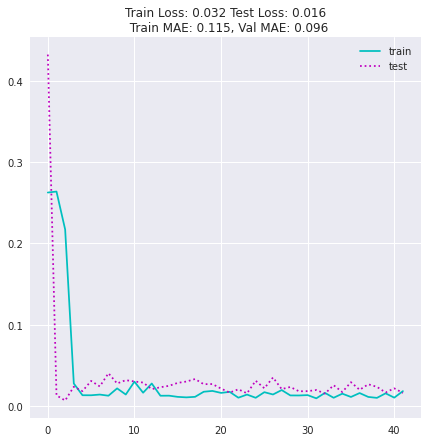

In [0]:
# Calculate the train loss and train metric, in this case mean absolute error
train_loss = np.mean(history.history['loss'])
train_mae = np.mean(history.history['mae'])
score = model.evaluate_generator(test_generator, verbose=0)  

title = 'Train Loss: {0:.3f} Test Loss: {1:.3f}\n  Train MAE: {2:.3f}, Val MAE: {3:.3f}'.format(train_loss, score[0], train_mae, score[1])

# Plot loss function
fig = pyplot.figure()
pyplot.style.use('seaborn')

pyplot.plot(history.history['loss'], 'c-', label='train')
pyplot.plot(history.history['val_loss'], 'm:', label='test')
pyplot.title(title)
pyplot.legend()
pyplot.grid(True)
fig.set_size_inches(w=7,h=7)
#pyplot.close()

In [0]:
predictions = model.predict(test_X)

ids = test_y
prognoze_df = pd.DataFrame(ids, columns=['true'])
prognoze_df['pred'] = predictions
df_predictions = spark.createDataFrame(prognoze_df)

rmse_evaluator = RegressionEvaluator(labelCol="true", predictionCol="pred", metricName="rmse")
mse_evaluator = RegressionEvaluator(labelCol="true", predictionCol="pred", metricName="mse")


validation_rmse = rmse_evaluator.evaluate(df_predictions)
validation_mse = mse_evaluator.evaluate(df_predictions)

print("RMSE: %f, MSE: %f" % (validation_rmse, validation_mse))

RMSE: 0.036037, MSE: 0.001299

#### 5. Results

In [0]:
display(df_predictions)

true,pred
0.6468511517744956,0.61810946
0.6410209552503824,0.6195384
0.6413100559044707,0.61546797
0.641647340000907,0.63781655
0.638049642972253,0.6547515
0.6386599665753282,0.6516571
0.6345804351231938,0.657494
0.6327494643139683,0.6603554
0.6303242310491167,0.6789549
0.630613331703205,0.6708583


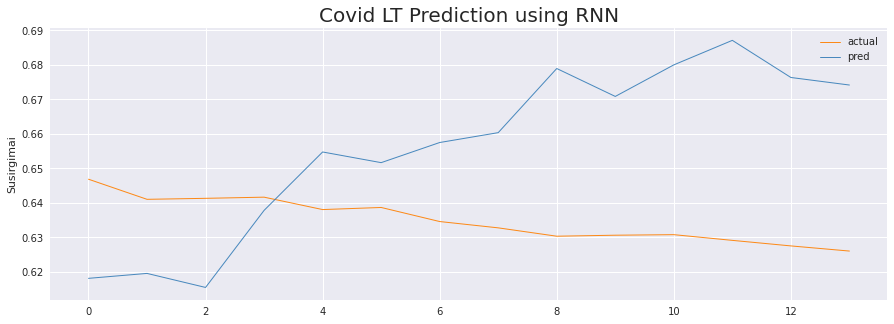

In [0]:
fig = pyplot.figure()

palette = pyplot.get_cmap('Set1')

pyplot.plot(prognoze_df.true, marker='', color=palette(4), linewidth=1, alpha=0.9, label='actual')
pyplot.plot(prognoze_df.pred, marker='', color=palette(1), linewidth=1, alpha=0.9, label='pred')
pyplot.title('Covid LT Prediction using RNN', loc='center', fontsize=20)
pyplot.ylabel('Susirgimai')
pyplot.legend()
fig.set_size_inches(w=15,h=5)